In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib

%run './../split_step_fourier.ipynb'
DEBUG = False

# showing figures inline
%matplotlib inline
# plotting options 
figure_size = (16, 9)
plt.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [5]:
# parameters of the filters
f_symbol = 32e9  # symbol rate (Baud) (Symbols per second)
n_up = 10  # samples per symbol (>1 => oversampling)

r_rc = .33
syms_per_filt = 4  # symbols per filter (plus minus in both directions)
t_sample_rc, rc = get_rc_ir(syms_per_filt, r_rc, f_symbol, n_up)

n_symbol = 30 # number of symbols

# modulation scheme and constellation points
M_bpsk = 2
modulation_bpsk = {'0': -1, '1': 1}

M_qpsk = 4
modulation_qpsk = {f"{i:02b}": np.cos(2 * np.pi * (i - 1) / M_qpsk + (np.pi/4)) + np.sin(2 * np.pi * (i - 1) / M_qpsk + (np.pi/4)) * (0 + 1j) for i in range(M_qpsk)}

M_qam = 16
qam = [ ((2*(m+1)-np.sqrt(M_qam)-1) + 1j*(2*(n+1)-np.sqrt(M_qam)-1)) for n in range(int(np.sqrt(M_qam))) for m in range(int(np.sqrt(M_qam))) ]
modulation_qam = {f"{i:04b}": symb for (i, symb) in zip(range(M_qam), qam)}

# Signalfolge generieren
send_bits_bpsk = np.random.choice([symbol for symbol in modulation_bpsk.keys()], size=n_symbol)
send_bits_qpsk = np.random.choice([symbol for symbol in modulation_qpsk.keys()], size=n_symbol)
send_bits_qam = np.random.choice([symbol for symbol in modulation_qam.keys()], size=n_symbol)

In [6]:
## Global Transmission parameters
z_length = 70  # [km]

alpha = 0.2  # Dämpfung [dB/km]
D = 17  # [ps/nm/km]
beta2 = - (D * np.square(1550e-9)) / (2 * np.pi * 3e8) * 1e-3 # [s^2/km] propagation constant, lambda=1550nm is standard single-mode wavelength
gamma = 1.3 # [1/W/km]

In [35]:
# simulate channel for multiple power inputs
all_sims = {}
for modulation, send_bits, name in [(modulation_bpsk, send_bits_bpsk, "bpsk"), (modulation_qpsk, send_bits_qpsk, "qpsk"), (modulation_qam, send_bits_qam, "16qam")]:
    sims ={}
    for power in [0,4,9]:
        send_rc = generate_signal(modulation, t_sample_rc, 1/f_symbol, send_bits, rc, syms_per_filt, power)
        send = zeroing(send_rc, 100 * int(1/f_symbol/t_sample_rc))

        ## Simulation of reference transmission (dz = 0.1 km)
        nz_ref = 100  # steps
        dz_ref = z_length / nz_ref  # [km]

        output_ref = splitstepfourier(send, t_sample_rc, dz_ref, nz_ref, alpha, beta2, gamma)

        d_nz = 1 # d_nz to use in loop
        ## Simulation of fibers with different step sizes
        step_sweep_sim = []
        for nz in np.arange(1, nz_ref+d_nz, step=d_nz):
            dz = z_length / nz
            output = splitstepfourier(send, t_sample_rc, dz, nz, alpha, beta2, gamma)
            step_sweep_sim.append((nz, output))

        sims[f"{power}"] = (output_ref, step_sweep_sim)
        
    all_sims[name] = sims

Text(0.5, 0, 'Anzahl simulierter Schritte (nz)')

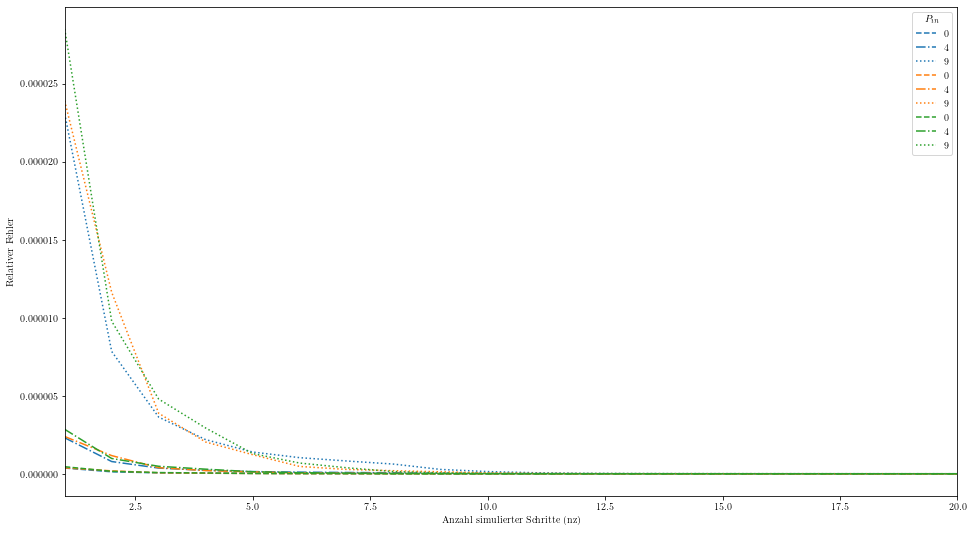

In [36]:
## Plots
fig1 = plt.figure(figsize=figure_size)
plot1 = fig1.add_subplot()
#fig2 = plt.figure(figsize=figure_size)
#plot2 = fig2.add_subplot()
for name, sims in all_sims.items():
    #plt.gca().set_prop_cycle(None)
    lines = [':', '-.', '--']
    if name == "bpsk":
        linestyle = "tab:blue"
    elif name == "qpsk":
        linestyle = "tab:orange"
    elif name == "16qam":
        linestyle = "tab:green"
    
    for key, data in sims.items():
        ref = data[0]
        signal = data[1]
        x_vals = []
        y_vals = []
        for n_steps, sim_out in signal:
            x_vals.append(n_steps)
            y_vals.append(abs(calc_relerr(sim_out, ref)))

        plot1.plot(x_vals, y_vals, label=f"{key}", color=linestyle, linestyle=lines.pop())
        #if key in ['-5', '0', '3', '5', '6', '7', '8', '9']:
        #    plot2.plot(x_vals, y_vals, label=key)

xmin = np.amin(x_vals)
xmax = np.amax(x_vals)

plot1.legend(loc='upper right', title='$P_{in}$')
plot1.set_xlim(xmin, 20)
plot1.set_ylabel("Relativer Fehler")
plot1.set_xlabel("Anzahl simulierter Schritte (nz)")

#plot2.legend(loc='upper right', title='$P_{in}$')
#plot2.grid()
#plot2.set_xlim(xmin, 10)
#plot2.set_ylabel("Relativer Fehler")
#plot2.set_xlabel("Anzahl simulierter Schritte (nz)")

In [8]:
output_fname = "steps_sweep_allmod"
output_path = "../../../bachelorarbeit-ausarbeitung/figures/plots/"

tikzplotlib.save(f'{output_path}{output_fname}_full.tex', figure=fig1, figureheight="\\figheight", figurewidth="\\figwidth")
tikzplotlib.save(f'{output_path}{output_fname}_zoom.tex', figure=fig2, figureheight="\\figheight", figurewidth="\\figwidth")
#tikzplotlib.save(f'{output_path}{output_fname}_full_noalpha.tex', figure=fig3, figureheight="\\figheight", figurewidth="\\figwidth")
tikzplotlib.save(f'{output_path}{output_fname}_zoom_noalpha.tex', figure=fig4, figureheight="\\figheight", figurewidth="\\figwidth")

fig1.savefig(f"{output_path}{output_fname}_full.pdf", bbox_inches='tight')
fig2.savefig(f"{output_path}{output_fname}_zoom.pdf", bbox_inches='tight')
fig3.savefig(f"{output_path}{output_fname}_full_noalpha.pdf", bbox_inches='tight')
fig4.savefig(f"{output_path}{output_fname}_zoom_noalpha.pdf", bbox_inches='tight')